## GCP Pub/Sub

O Pub/Sub é um serviço de mensagens assíncrono e escalável.
Nesse notebook iremos explorar os conceitos básicos de tópico, assinaturas, esquemas e retenção.

Os dados utilizados podem ser acessados por esse [link](https://drive.google.com/file/d/1HotwwPiB9lyfQMk_2Pj_uEtmQrRu6Ljx/view).

Referências: [documentação oficial](https://cloud.google.com/pubsub/docs/overview)

### 1) Tópicos

O primeiro exemplo que vamos ver é o mesmo do [tutorial inicial](https://cloud.google.com/python/docs/reference/pubsub/2.27.1) do cliente Python do Pub/Sub, apenas com alguns comentários para facilitar a compreensão.

In [ ]:
import os
from google.cloud import pubsub_v1
from google.api_core.exceptions import AlreadyExists
from google.pubsub_v1 import BigQueryConfig, DeadLetterPolicy, Topic, Subscription

Antes de iniciar, vamos configurar o ID do projeto da GCP, pois ele será utilizado nos exemplos abaixo. Para obter essa informação, acesse o console da GCP e copie o project id como mostrado na imagem:
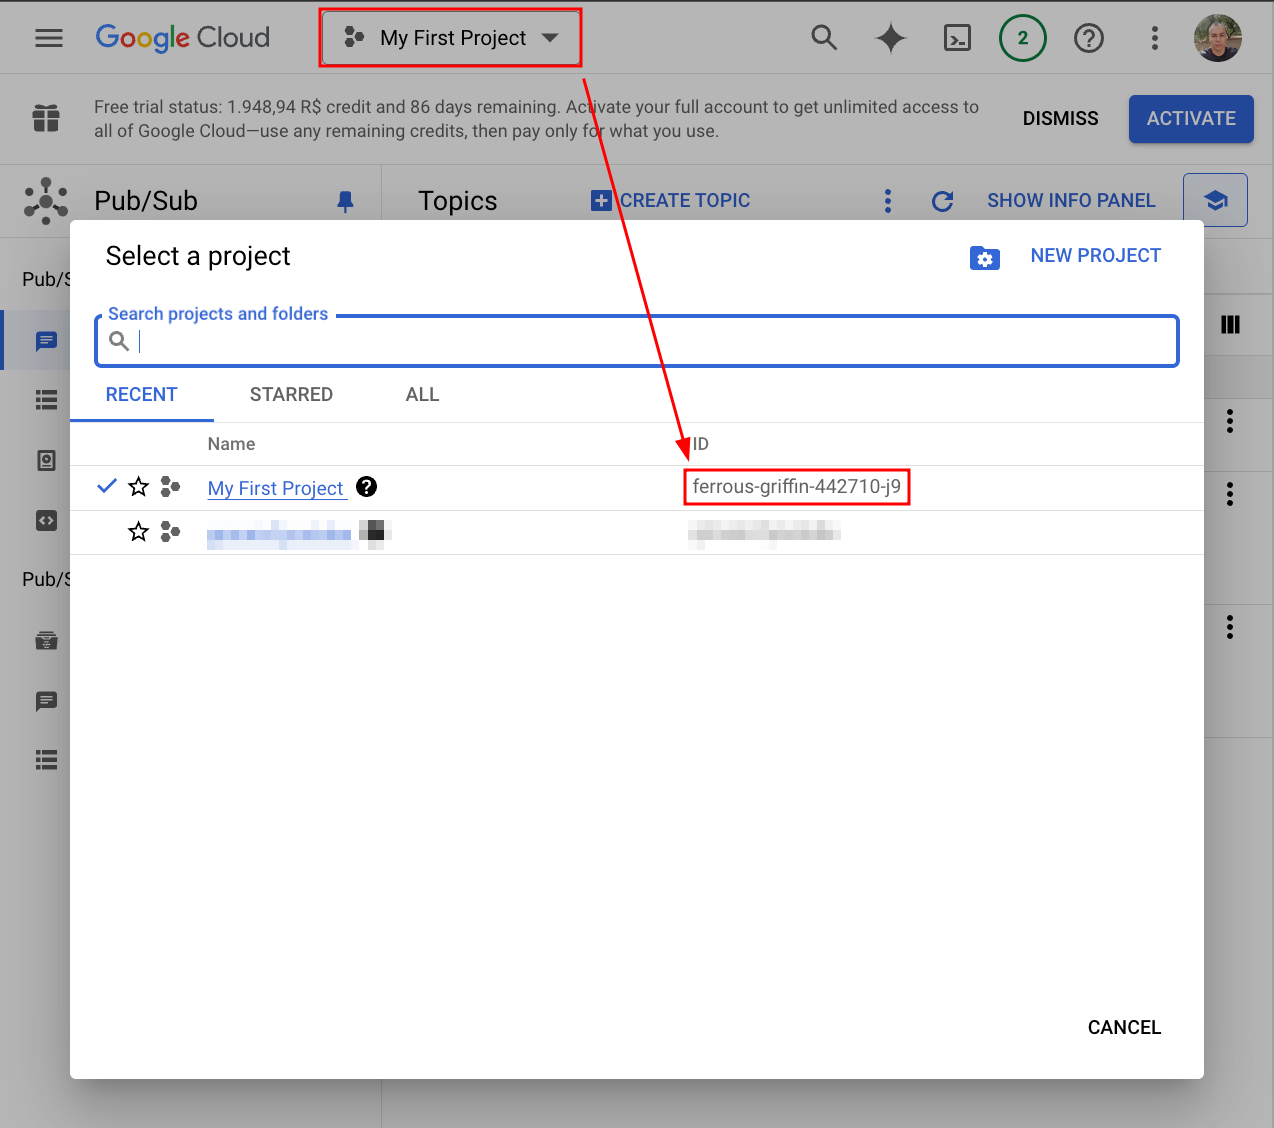

In [ ]:
GOOGLE_CLOUD_PROJECT="ferrous-griffin-442710-j9"

In [ ]:
# Criação do cliente de publicação, com ele é possível criar tópicos e publicar mensagens
publisher = pubsub_v1.PublisherClient()

# Os nomes dos tópicos seguem o formato projects/<nome-do-projeto>/topics/<nome-do-tópico>
# o código abaixo configura esse nome
topic_name = "projects/{project_id}/topics/{topic}".format(
    project_id=GOOGLE_CLOUD_PROJECT,
    topic='aula-pdm-primeiro-topico',
)
topic_name

In [ ]:
# Criação do tópico. Lembre-se, caso execute esse código duas vezes,
# a segunda vez lançará uma exceção dizendo que o tópico já existe
publisher.create_topic(name=topic_name)

In [ ]:
# Publicação da nossa primeira mensagem
future = publisher.publish(topic_name, b"My first message!", versao="python3.11")

# A função que publica mensagens retorna um Future, pois é uma operação assíncrona.
# Usamos a função result() para aguardar a resposta desse future
future.result()

### 2) Assinaturas ou subscriptions

Agora que publicamos nossa primeira mensagem, precisamos criar uma assinatura no tópico para consumir a mensagem.

In [ ]:
# Configuramos o nome da assinatura para o formato esperado assim como fizemos com o tópico
subscription_name = "projects/{project_id}/subscriptions/{sub}".format(
    project_id=GOOGLE_CLOUD_PROJECT,
    sub='aula-pdm-minha-primeira-assinatura',
)
subscription_name

In [ ]:
# A função abaixo será responsável por receber a mensagem 
def callback(message):
    print(f"data: {message.data.decode('utf-8')} | attributes: {message.attributes}")
    # Essa chamada do ack é como o Pub/Sub controla quais mensagens foram processadas
    message.ack()

In [ ]:
# Criação do subscriber, como ele é possível criar assinaturas e "se inscrever" em tópicos
subscriber = pubsub_v1.SubscriberClient()

In [ ]:
# Criação da assinatura. Lembre-se, caso execute esse código duas vezes,
# a segunda vez lançará uma exceção dizendo que a assinatura já existe
subscriber.create_subscription(
    name=subscription_name, topic=topic_name
)

In [ ]:
# A chamada abaixo registra a assinatura com a função de callback
# Dessa forma, toda mensagem que chegar no tópico da assinatura, executará o código cadastrado
future = subscriber.subscribe(subscription_name, callback)

In [ ]:
# Assim como na publicação, a função result é para aguardar algo
# Por quanto tempo devemos esperar por novas mensagens?
try:
    future.result()
except KeyboardInterrupt:
    future.cancel()

### 3) Assinatura do BigQuery

Agora que já rodamos alguns códigos simples, vamos ver como podemos criar uma assinatura para ler os dados de um tópico de forma automática e inserir em uma tabela do BigQuery.

Essa seção foi baseada na [documentação oficial](https://cloud.google.com/pubsub/docs/create-bigquery-subscription?hl=pt-br).

Antes de criar a assinatura e inserir os dados, precisamos preparar o BigQuery.
Vamos realizar três procedimentos:
1. Criar um dataset no BigQuery, o dataset é onde as tabelas ficam agrupadas, como o esquema em bancos relacionais.
2. Criar a tabela no dataset do BigQuery.
3. Ajustar a permissão do Pub/Sub para conseguir enviar os dados.

Para criação do dataset e da tabela, vamos executar o comando a seguir no [BigQuery Studio](https://console.cloud.google.com/bigquery).

```sql
-- Criação do dataset
CREATE SCHEMA aula_pdm;

-- Criação da tabela
CREATE TABLE aula_pdm.clientes
(
    city       STRING,
    client_id  STRING,
    cnae_id    STRING,
    cod_city   INTEGER,
    cod_tract  STRING,
    cod_uf     INTEGER,
    state      STRING,
    client     STRING,
    company_id STRING
);
```

O último procedimento para habilitar que o Pub/Sub acesse o BigQuery é a gestão de acesso.
Vamos precisar acessar a página de IAM e depois clicar em `Grant Access`.

No campo `New principals` devemos incluir o nome da Service Account, ela segue esse padrão `service-<project-number>@gcp-sa-pubsub.iam.gserviceaccount.com` onde project-number é o número do projeto da GCP.
Para obter o project-number, você pode acessar a página de [IAM/Settings](https://console.cloud.google.com/iam-admin/settings).

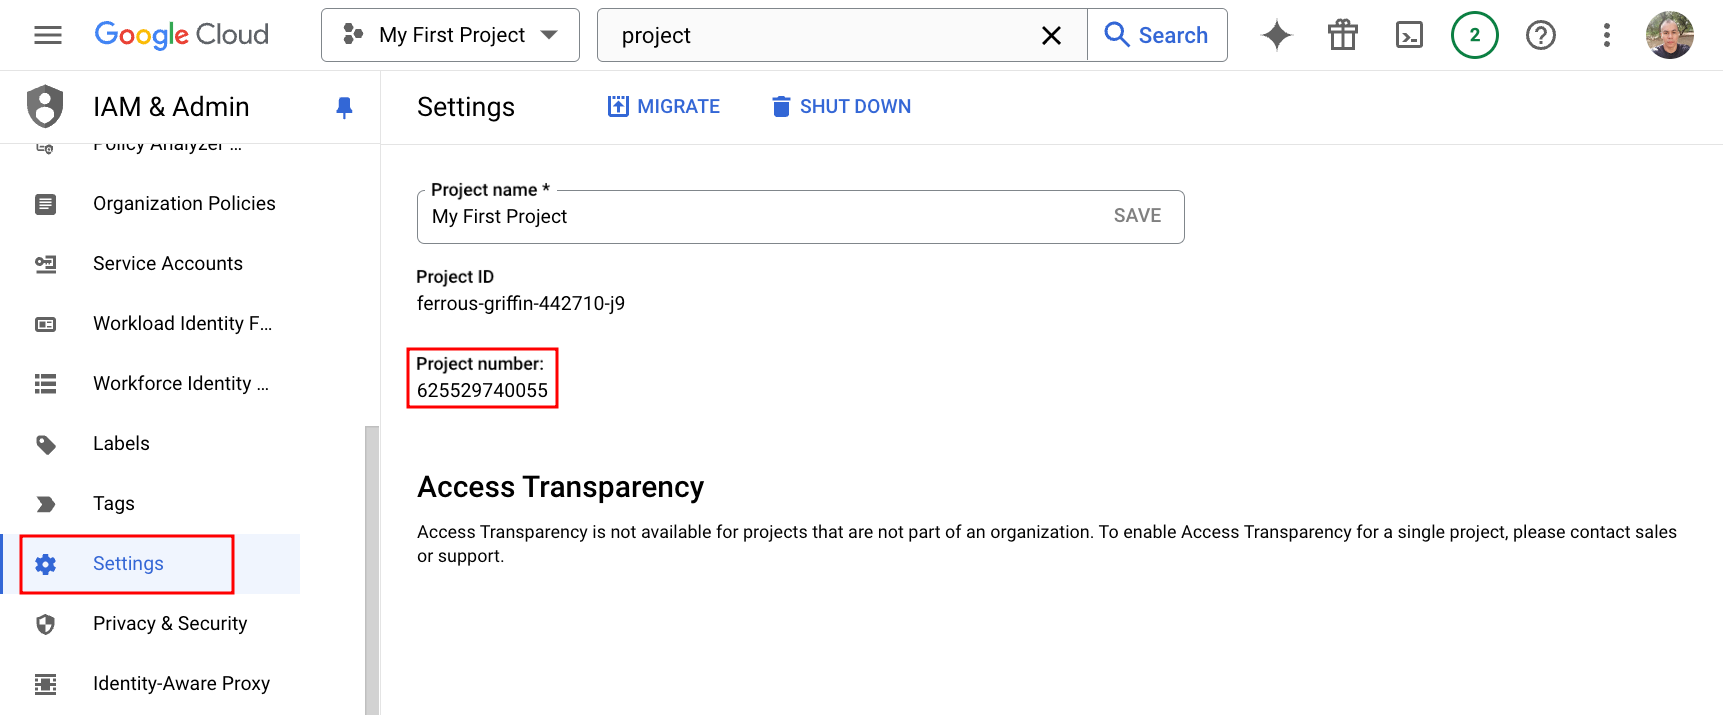

Portanto o valor que devo inserir no campo é `service-625529740055@gcp-sa-pubsub.iam.gserviceaccount.com` e no campo Assign roles, temos que preencher com `BigQuery Data Editor`, adicionar outra role clicando no botão `Add Another Role` e depois selecionando `Pub/Sub Subscriber`, após preencher esses valores, clique em save.

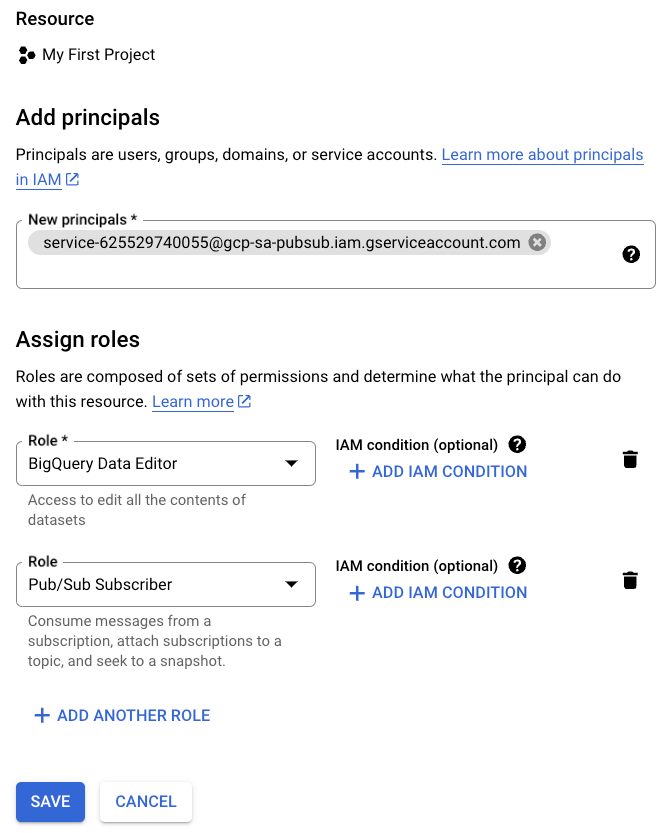

Agora já temos tudo pronto para a criação do tópico e da assinatura do BigQuery.

In [ ]:
# Primeiro vamos criar o código que irá receber os dados de clientes.
# O código é praticamente igual ao anterior, exceto que agora estamos configurando um período de retenção para as mensagens.

topico_clientes = "projects/{project_id}/topics/{topic}".format(
    project_id=GOOGLE_CLOUD_PROJECT,
    topic='aula-pdm-clientes',
)
topico_clientes

In [ ]:
publisher = pubsub_v1.PublisherClient()

In [ ]:
topico_obj = Topic({
    "name": topico_clientes,
    "message_retention_duration": "259200s" # 3 dias
})
try:
    publisher.create_topic(request=topico_obj)
except AlreadyExists:
    print(f"O tópico '{topico_clientes}' já existe")

Vamos primeiro criar a assinatura através da interface gráfica.
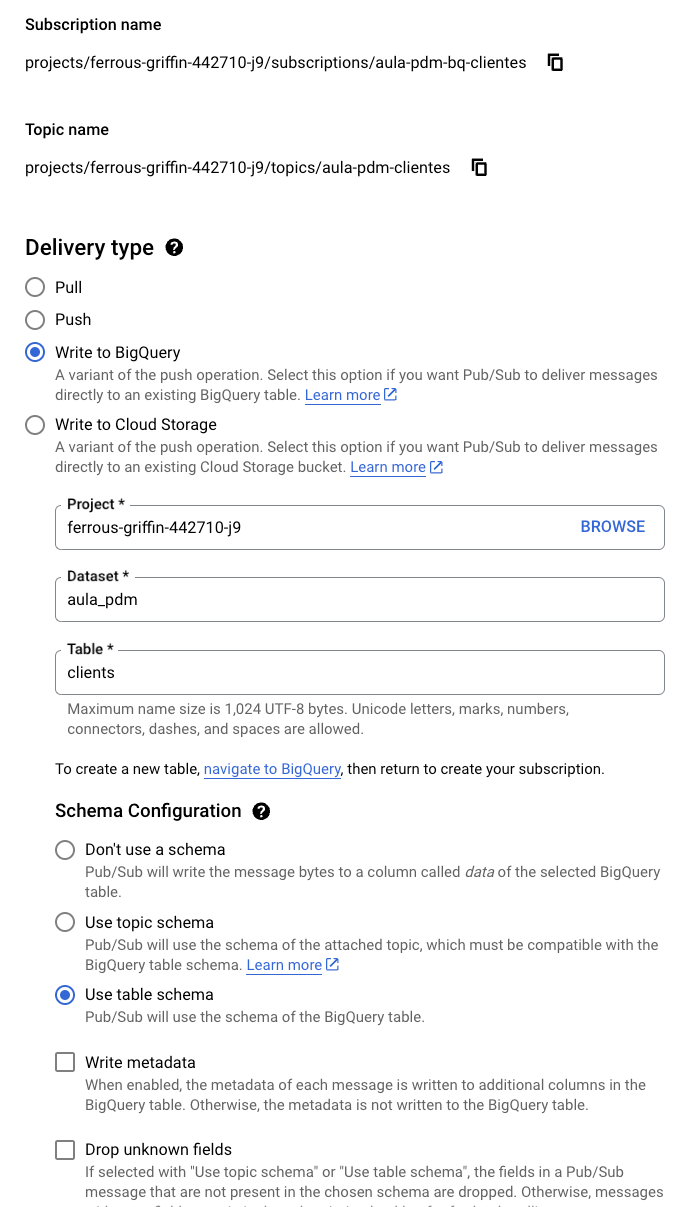

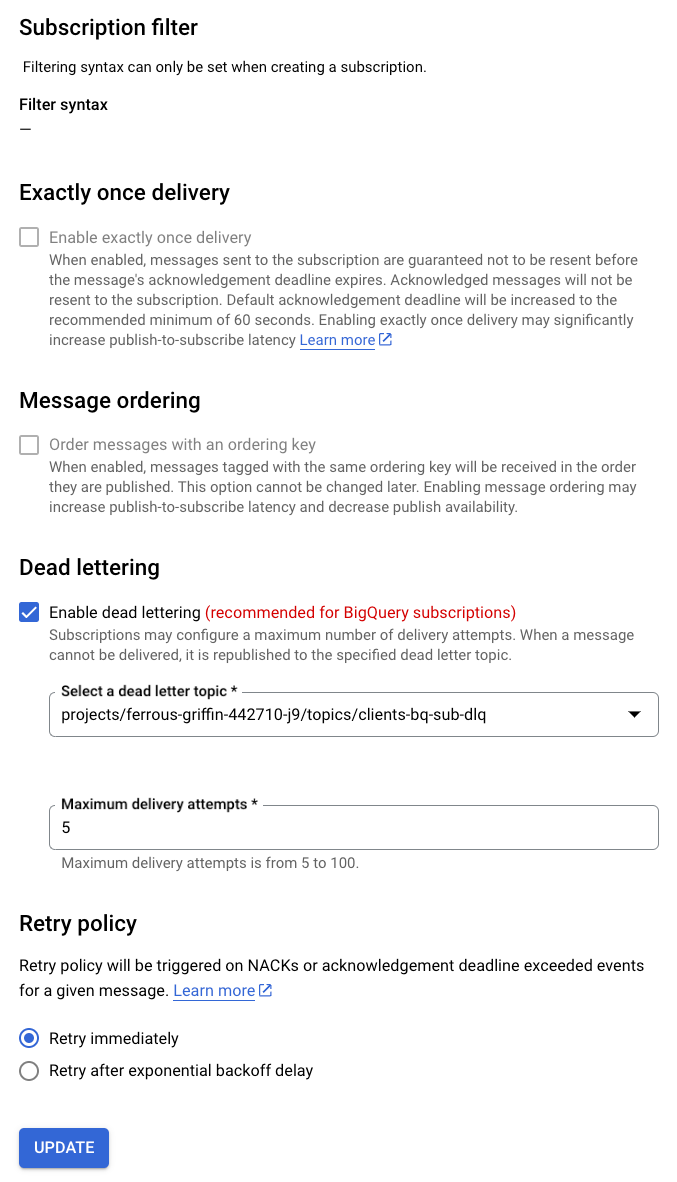

In [ ]:
assinatura_clientes_bq = "projects/{project_id}/subscriptions/{sub}".format(
    project_id=GOOGLE_CLOUD_PROJECT,
    sub="aula-pdm-clientes-bq-python",
)
assinatura_clientes_bq

In [ ]:
topico_dlq = "projects/{project_id}/topics/{topic}".format(
    project_id=GOOGLE_CLOUD_PROJECT,
    topic='aula-pdm-clientes-bq-dlq',
)
topico_dlq

In [ ]:
try:
    publisher.create_topic(name=topico_dlq)
except AlreadyExists:
    print(f"O tópico '{topico_dlq}' já existe")

In [ ]:
clientes_assinatura_bq = Subscription({
    "name": assinatura_clientes_bq,
    "topic": topico_clientes,
    "bigquery_config": BigQueryConfig({
        "table": f"{GOOGLE_CLOUD_PROJECT}.aula_pdm.clientes",
        "use_table_schema": True,
        "drop_unknown_fields": True
    }),
    "dead_letter_policy": DeadLetterPolicy({
        "dead_letter_topic": topico_dlq
    })
})

In [ ]:
try:
    subscriber.create_subscription(
        request=clientes_assinatura_bq
    )
except AlreadyExists:
    printf(f"A assinatura {assinatura_clientes_bq} já existe")

### 4) Envio de mensagens para o tópico

In [ ]:
import csv
import json
from concurrent import futures

from google.cloud.pubsub_v1.futures import Future

In [ ]:
def csv_to_list_of_dict(csv_path: str) -> list[dict]:
    csvfile = open(csv_path, "r")
    reader = csv.DictReader(csvfile)
    data = [row for row in reader]
    csvfile.close()
    return data

In [ ]:
dados_dir = "../dados"
clientes_csv = f"{dados_dir}/clients.csv"
vendas_csv = f"{dados_dir}/vendas.csv"

In [ ]:
clientes_dados = csv_to_list_of_dict(clientes_csv)

In [ ]:
clientes_dados[0:3]

In [ ]:
vendas_dados = csv_to_list_of_dict(vendas_csv)

In [ ]:
vendas_dados[0]

In [ ]:
len(vendas_dados)

In [ ]:
def publica_mensagens(data: list[dict], topico: str):
    total = len(data)
    finished = []

    def done_callback(future: Future):
        f = len(finished) + 1
        perc = f / total * 100
        if f % 100 == 0:
            print(f"Publicação finalizada [{f} / {total} ({perc:.2f}%)]")
        finished.append(True)
    
    publish_futures = []
    for idx, row in enumerate(data):
        idx = idx + 1
        row_as_json = json.dumps(row).encode("utf-8")
        future = publisher.publish(topico, row_as_json)
        future.add_done_callback(done_callback)
        publish_futures.append(future)
    
        perc = idx / total * 100
        if idx % 100 == 0:
            print(f"Publicando {idx}/{total} ({perc:.2f}%)")

    futures.wait(publish_futures, timeout=60, return_when=futures.ALL_COMPLETED)

In [ ]:
publica_mensagens(clientes_dados[0:1000], topico_clientes)

In [ ]:
clientes_dados[0]

#### Dados de vendas

Como seria feita a inserção dos dados de vendas? Lembre-se de que é necessário criar a tabela no BigQuery.
Você pode explorar os dados como fizemos logo acima para criar o esquema da tabela.

### 5) Assinatura do Google Cloud Storage (GCS)

Existe um tipo de assinatura que envia os dados para o GCS em formato Avro. Essa funcionalidade pode ser interessante quando você tem um grande volume de dados ou quer economizar ou não precisa acessar os dados pelo BigQuery.

Essa seção foi baseada na [documentação oficial](https://cloud.google.com/pubsub/docs/create-cloudstorage-subscription?hl=pt-br).

Para criar uma assinatura do GCS é necessário criar um bucket e ajustar as permissões do mesmo.
Vamos criar um bucket pela [interface da GCP](https://console.cloud.google.com/storage/browser).

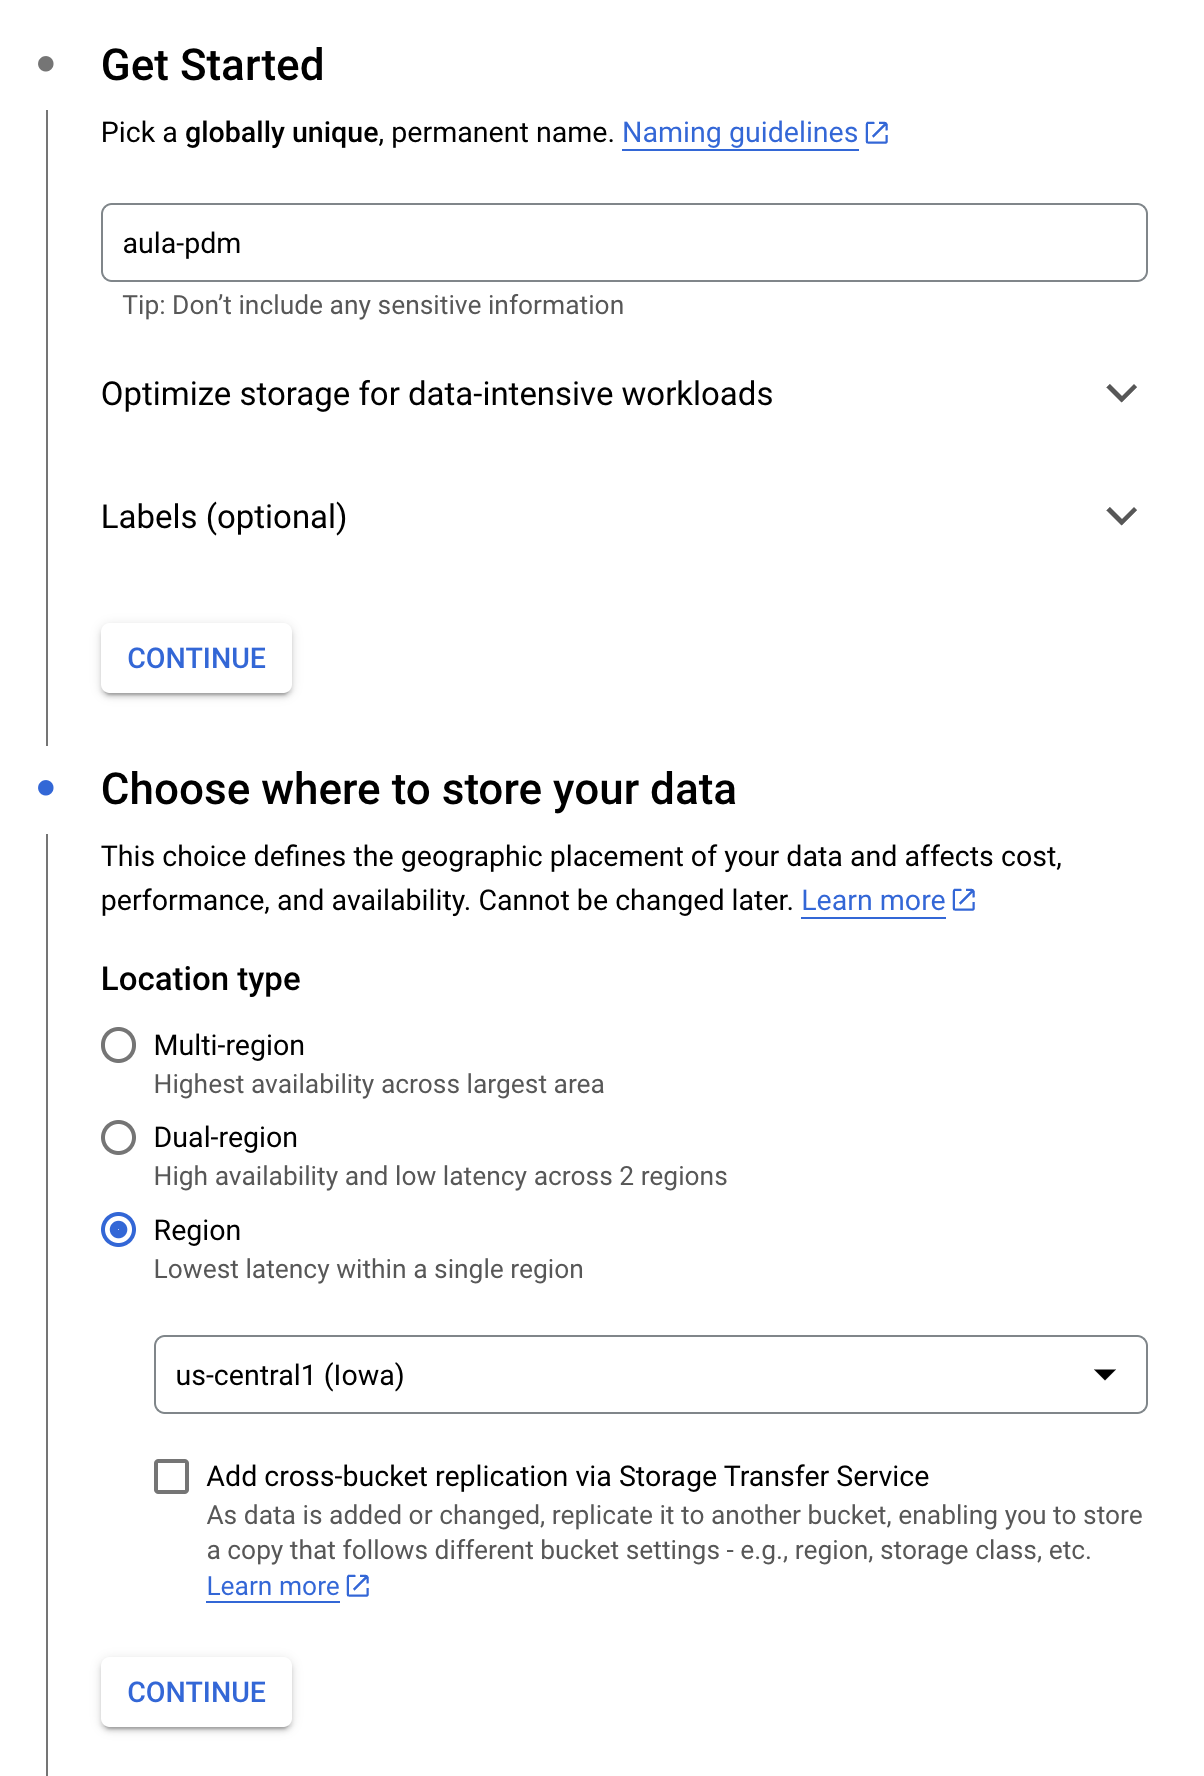

Para alterar a permissão, vamos conceder o papel `Storage Admin` a Service Account do Pub/Sub assim como fizemos na seção anterior do BigQuery.
Acesse a página de [IAM](https://console.cloud.google.com/iam-admin/iam) e clique no botão `Grant Access`.

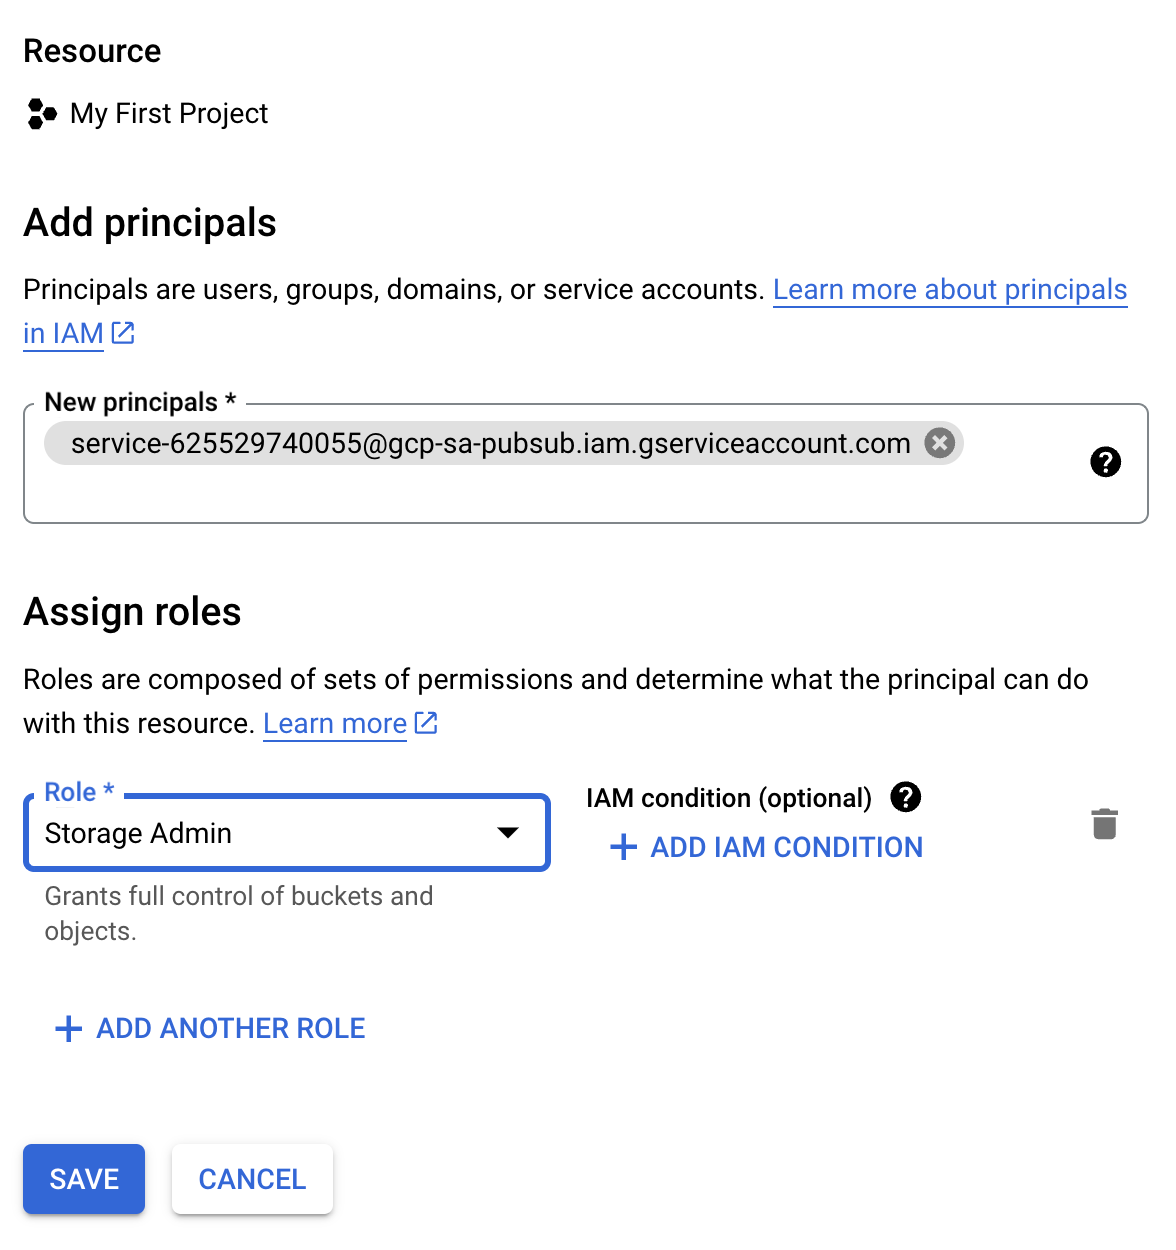

Agora vamos criar a assinatura no Pub/Sub através da interface gráfica.

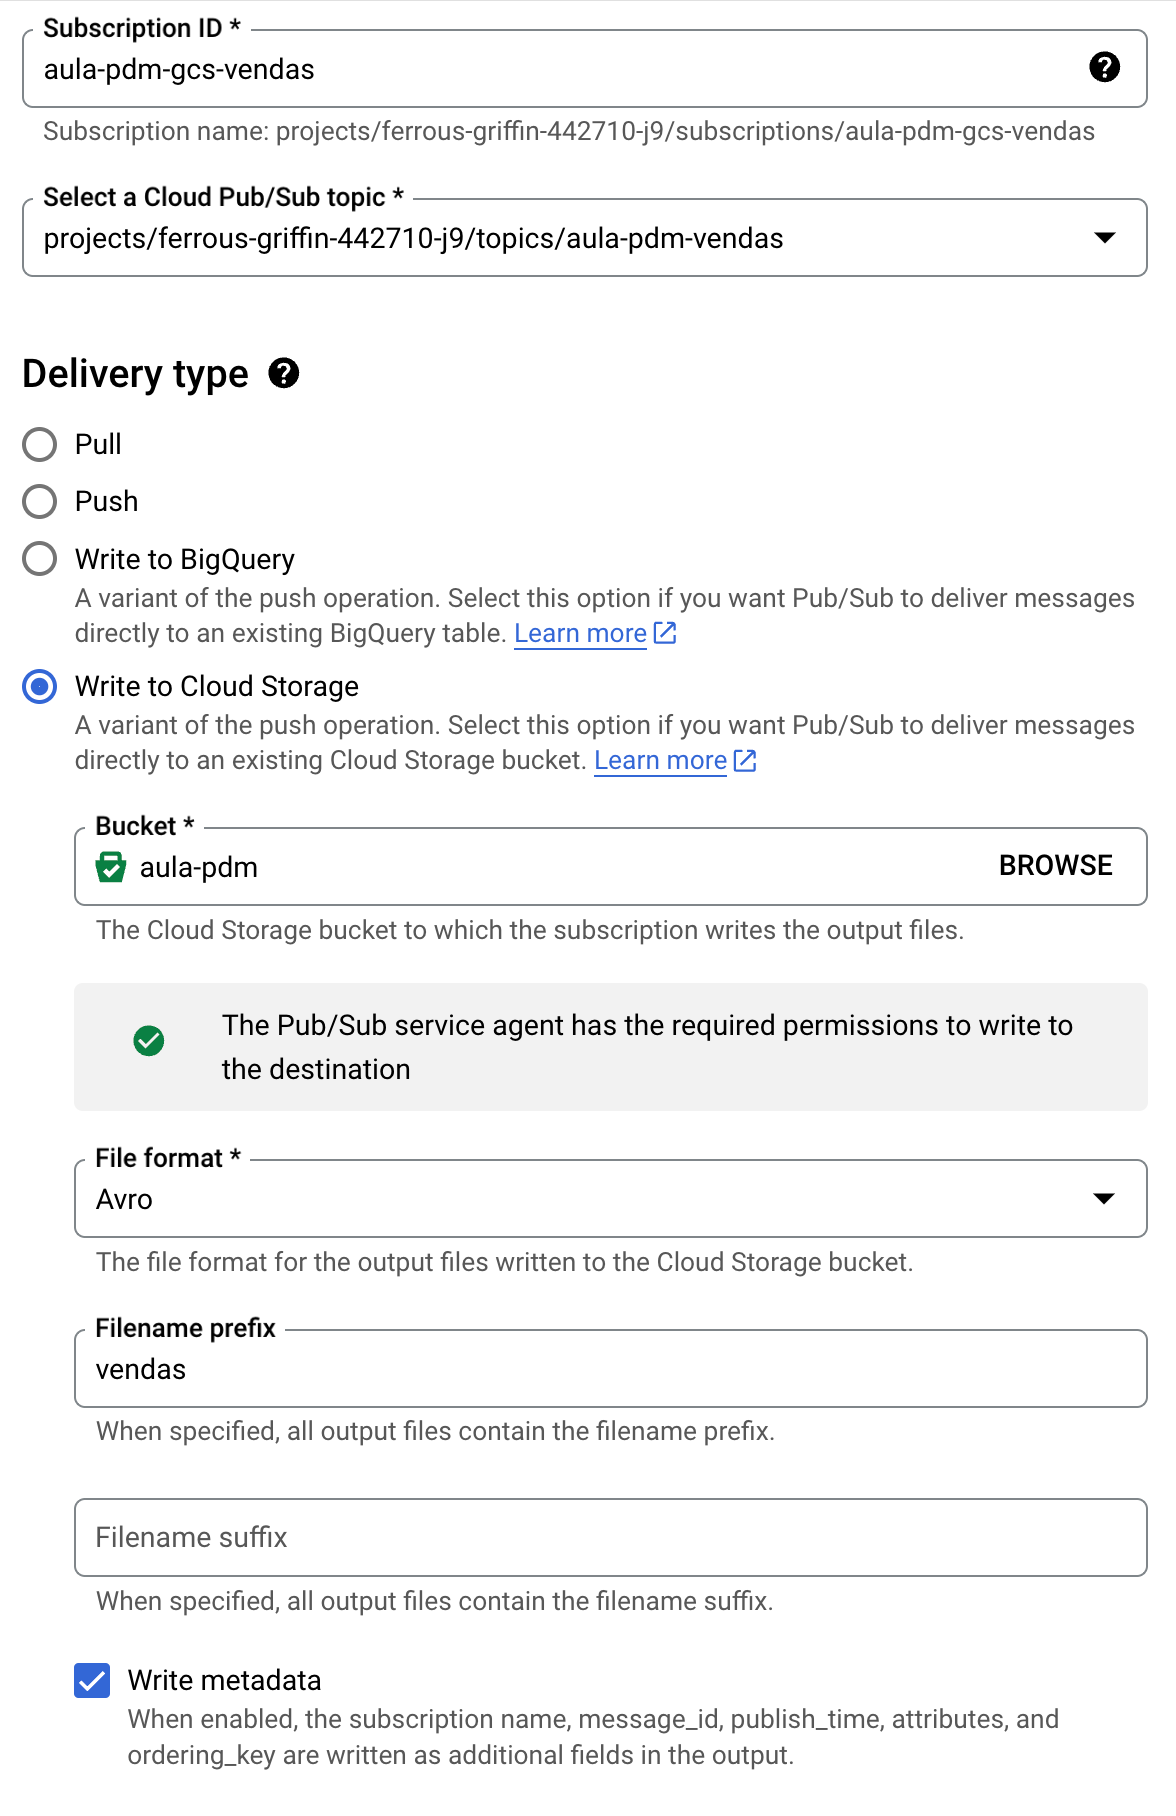

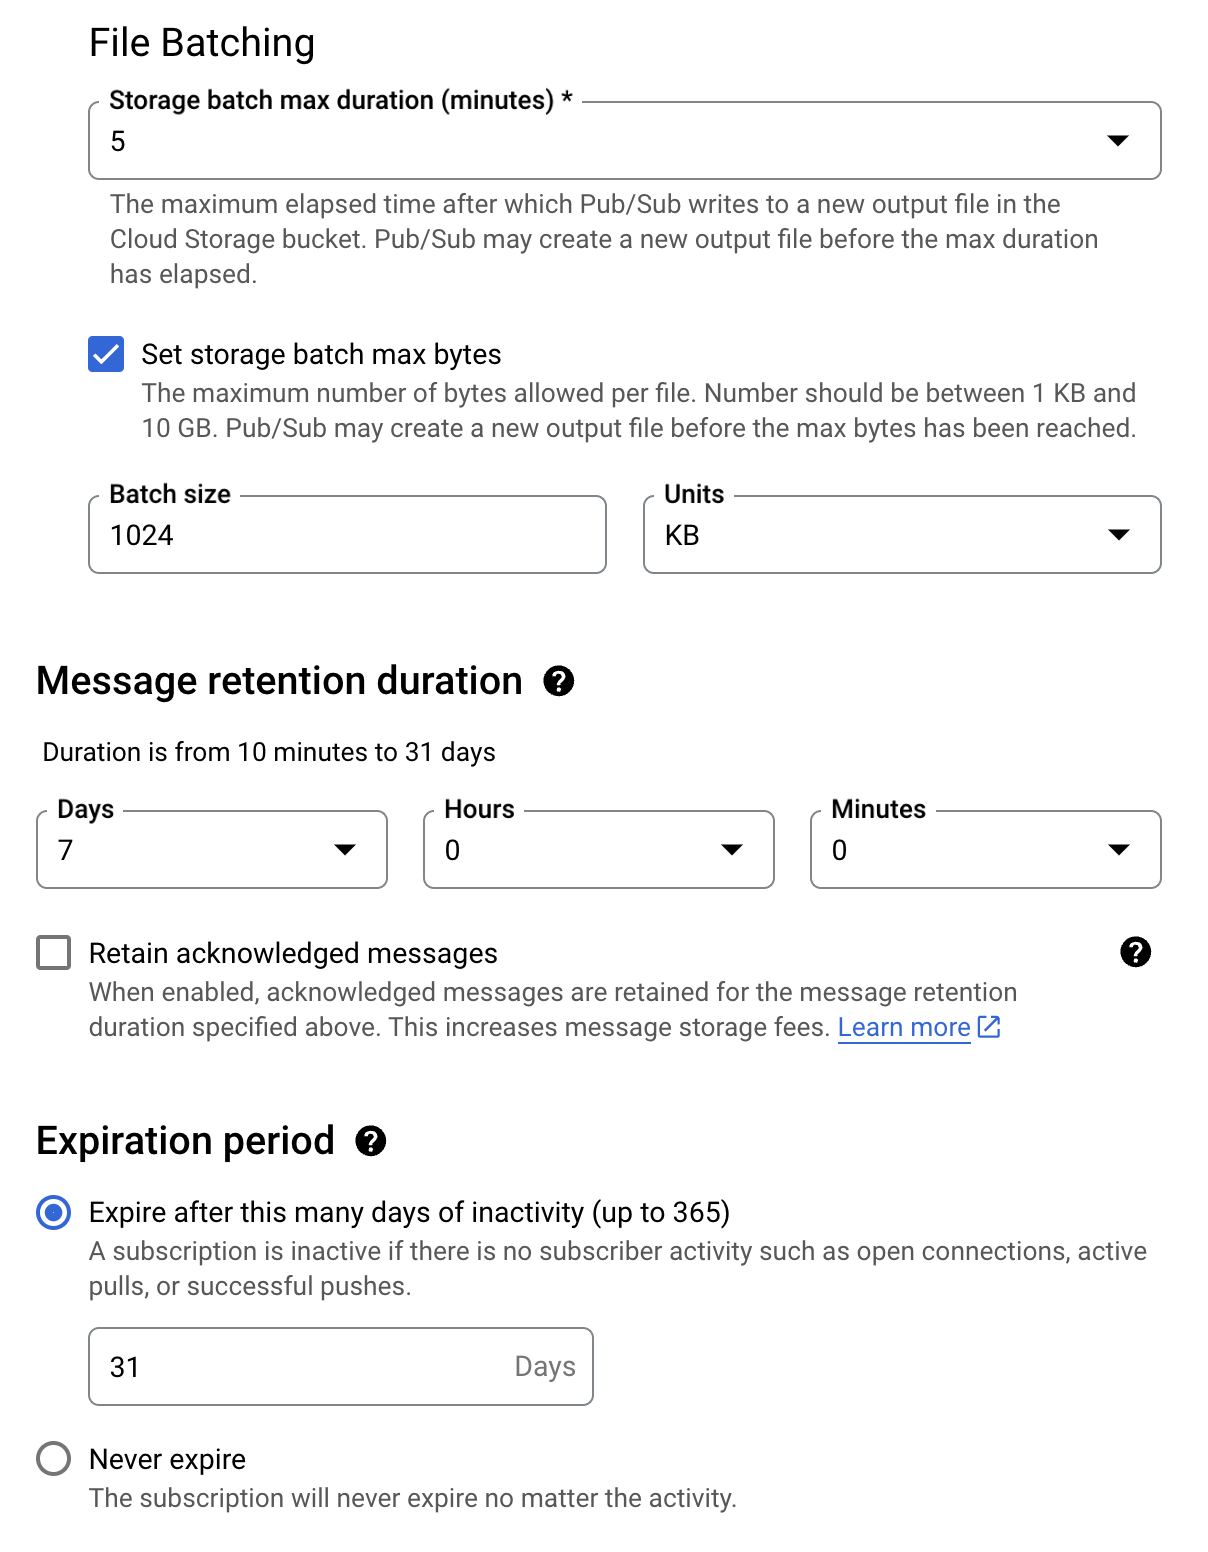

### 6) Envio dos dados de vendas

In [ ]:
topico_vendas = "projects/{project_id}/topics/{topic}".format(
    project_id=GOOGLE_CLOUD_PROJECT,
    topic='aula-pdm-vendas',
)
topico_vendas

In [ ]:
publisher = pubsub_v1.PublisherClient()

In [ ]:
try:
    publisher.create_topic(name=topico_vendas)
except AlreadyExists:
    print(f"O tópico '{topico_vendas}' já existe")

In [ ]:
publica_mensagens(vendas_dados[0:1000], topico_vendas)

### 7) Dados de vendas no BigQuery

Nós podemos ler os dados de vendas no BigQuery de duas formas, com uma tabela nativa ou tabela externa.
Como o formato Avro já tem o esquema dos dados, a criação da tabela é bem simples.

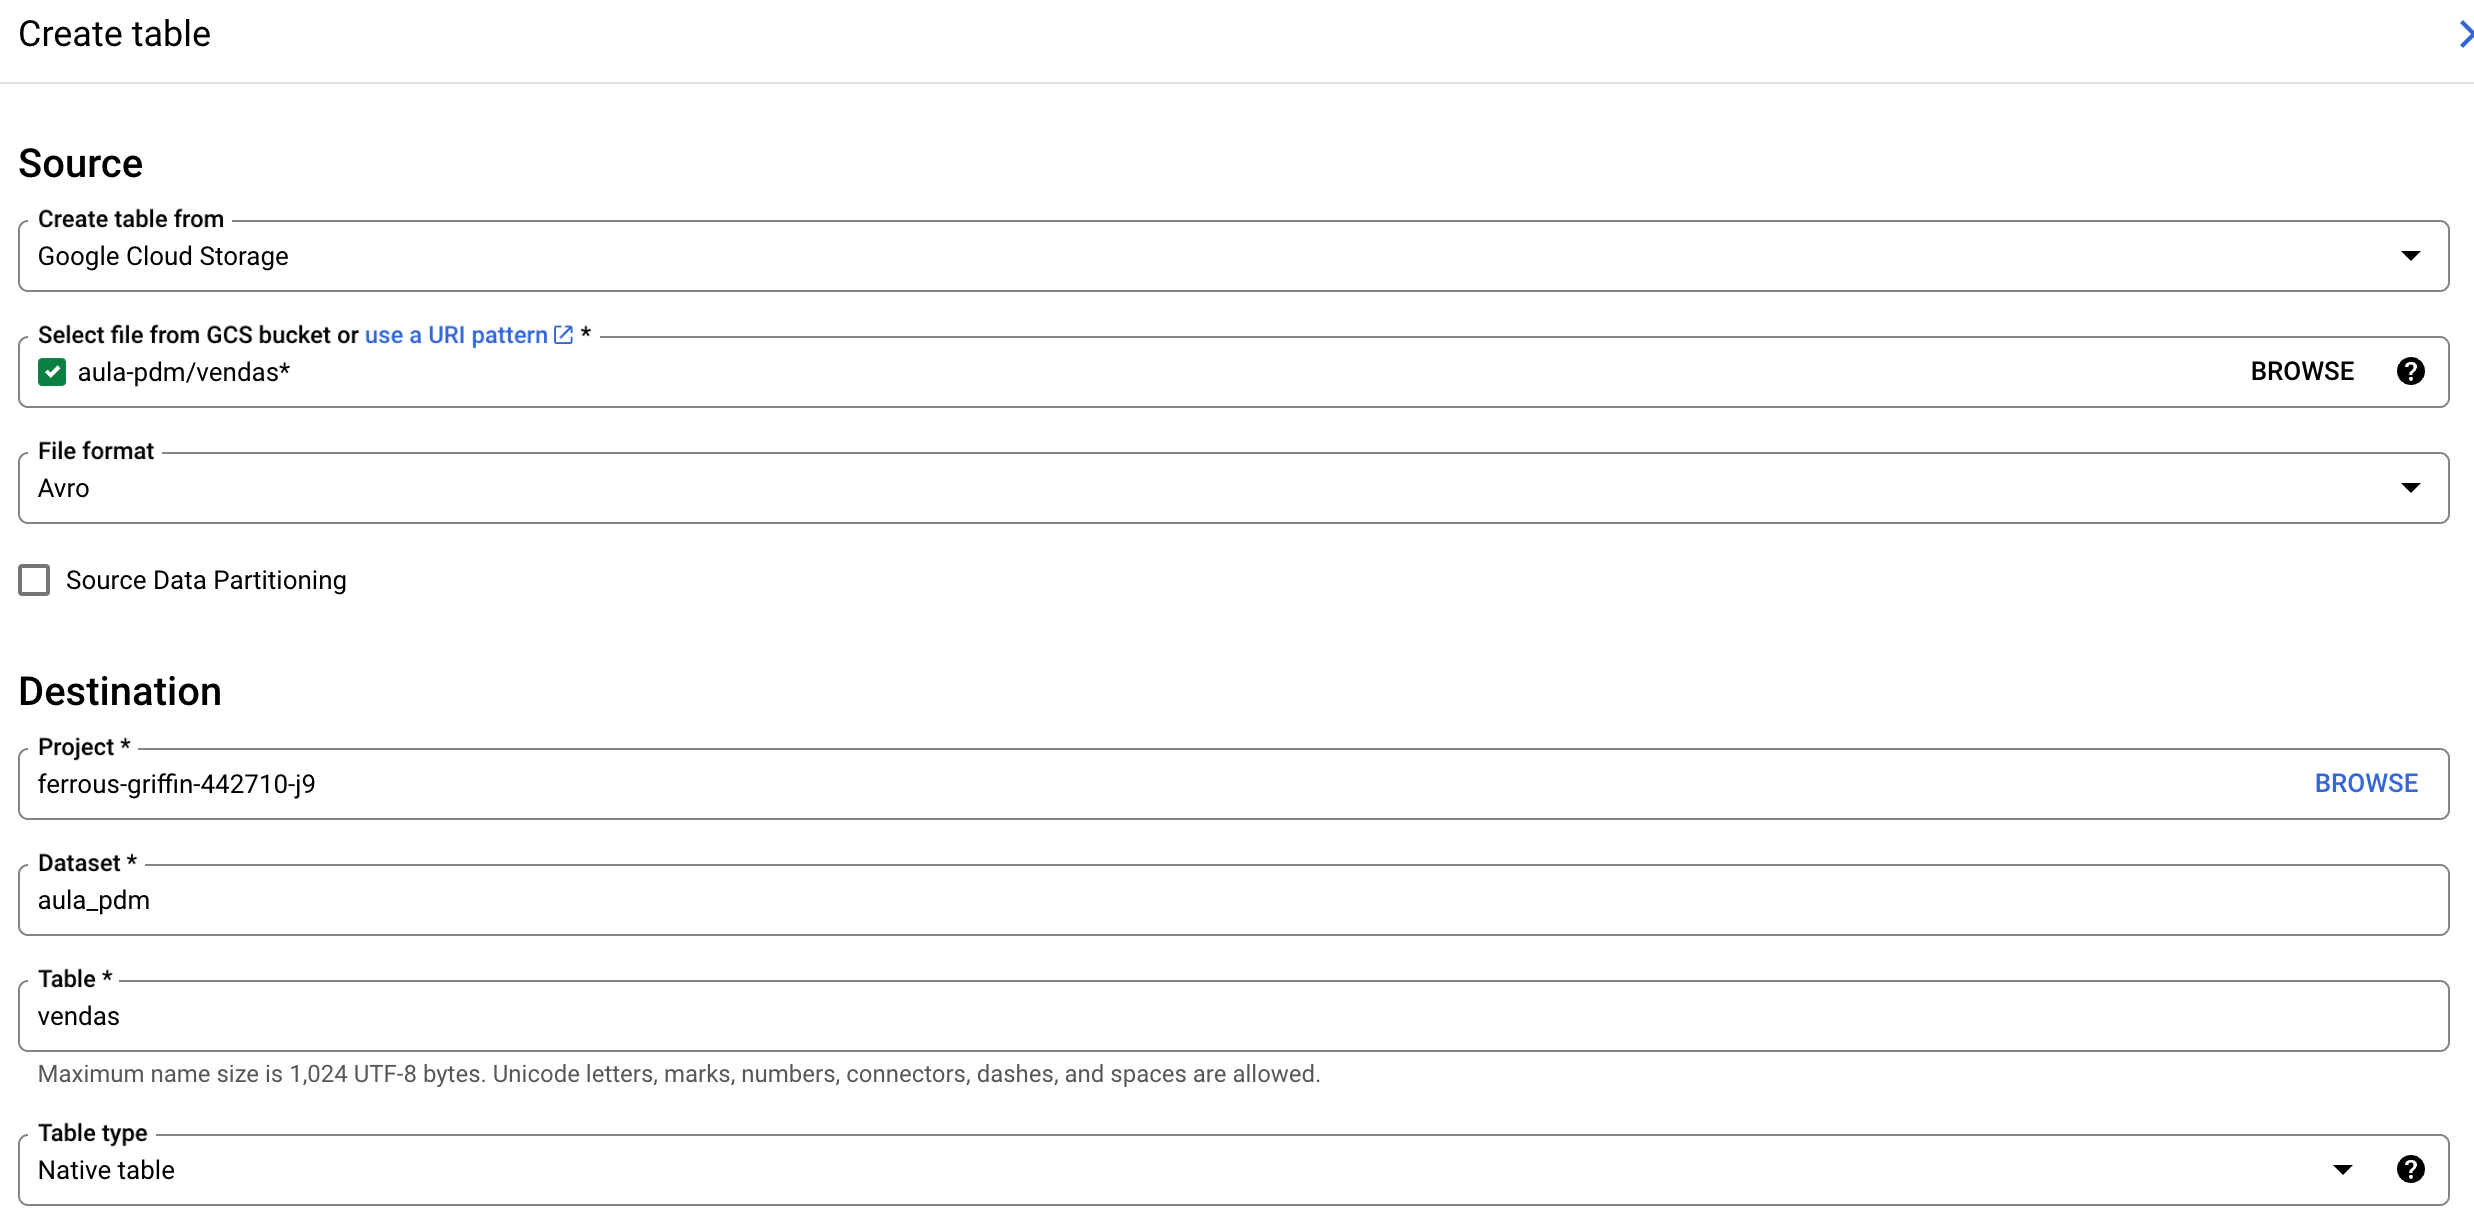

### 8) Leitura de dados no BigQuery

Os dados do Pub/Sub para o GCS não levam um esquema de dados, portanto os dados de vendas ficam em uma tabela do tipo `bytes`.
O conteúdo dessa coluna é na verdade uma string com encode base64, isso nos ajuda muito durante a conversão.

```sql
SELECT * FROM `aula_pdm.vendas` LIMIT 10;
-- A consulta acima vai retornar os dados mais ou menos assim
```

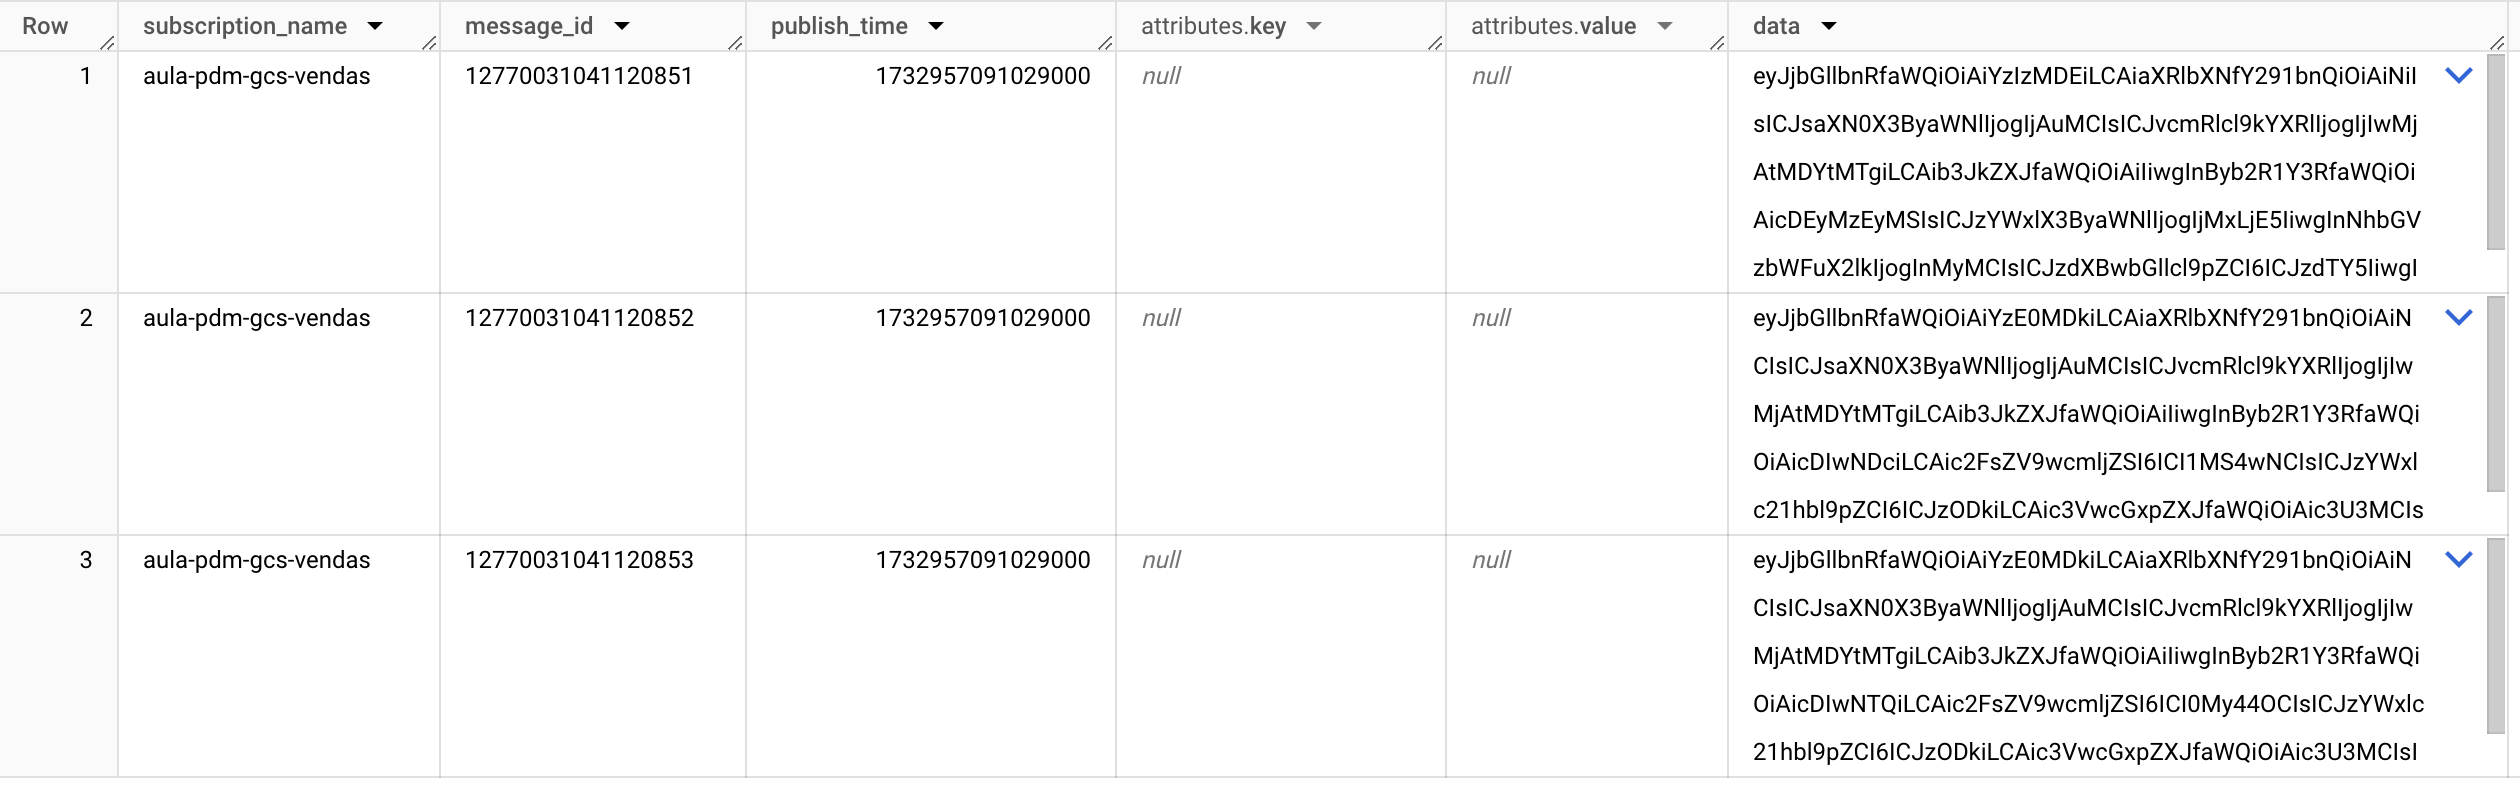

Você pode copiar o conteúdo da coluna data e usar algum site de decode de dados em base64 para confirmar de que o conteúdo é o json dos dados de vendas.
A saída será algo desse tipo:
```json
{"client_id": "c2301", "items_count": "6", "list_price": "0.0", "order_date": "2020-06-18", "order_id": "", "product_id": "p123121", "sale_price": "31.19", "salesman_id": "s20", "supplier_id": "su69", "company_id": "0603", "product": "Product p123121", "salesman": "Salesman s20", "supplier": "Supplier su69", "client": "Client c2301"}
```

O BigQuery consegue fazer a conversão desse dado em praticamente toda função de manipulação de string/bytes.
No exemplo abaixo, vamos fazer o parser da coluna para o formato JSON e vamos extrair algumas outras colunas.

```sql
WITH data_with_json AS (
  SELECT PARSE_JSON(CAST(data AS STRING)) data_json
  FROM `aula_pdm.vendas`
),
data_fmt AS (
  SELECT
    JSON_EXTRACT_SCALAR(data_json, '$.client')                       cliente
  , CAST(JSON_EXTRACT_SCALAR(data_json, '$.items_count') AS NUMERIC) qtd_itens
  , CAST(JSON_EXTRACT_SCALAR(data_json, '$.order_date') AS DATE)     data_pedido
  , CAST(JSON_EXTRACT_SCALAR(data_json, '$.list_price') AS FLOAT64)  preco_tabela
  , CAST(JSON_EXTRACT_SCALAR(data_json, '$.sale_price') AS FLOAT64)  preco_venda
  FROM data_with_json
)
SELECT *
FROM data_fmt
WHERE preco_venda > 300
```

O resultado da consulta acima vai ser parecido com esse abaixo.

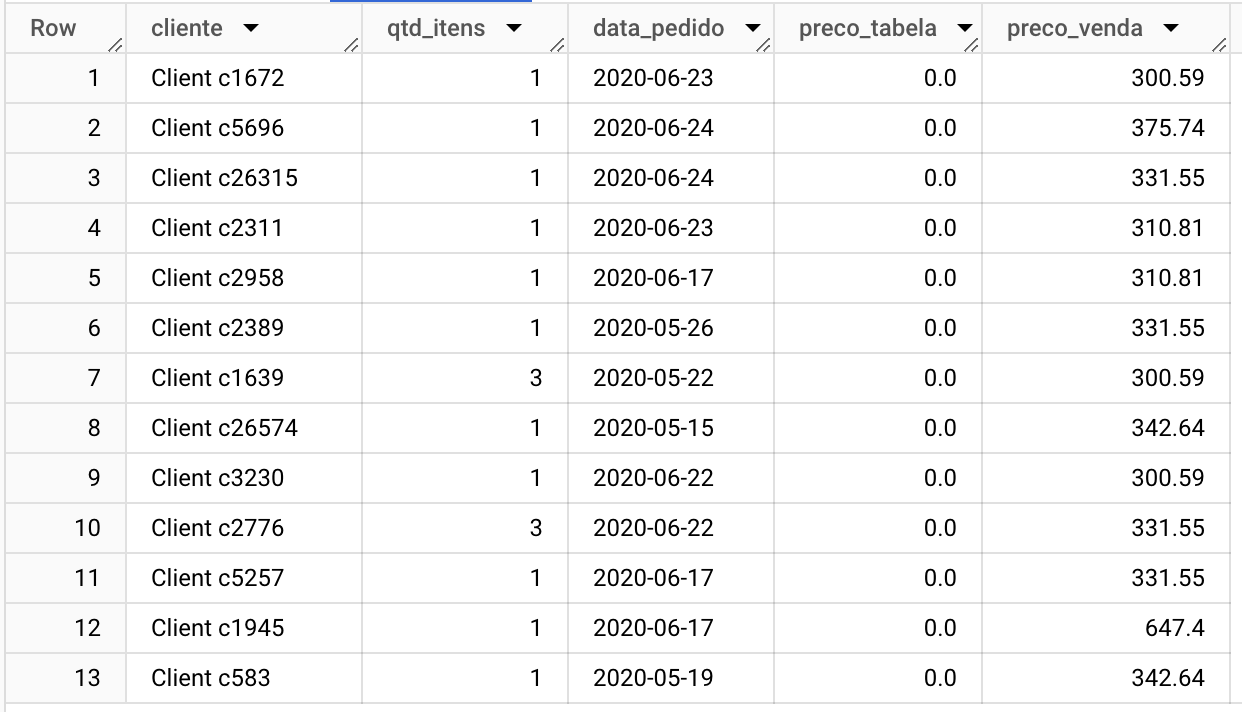